In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random as ran

In [2]:
path = 'C:/Users/sharmas/OneDrive - Ohio University/Teaching/CHE7120/Fall2022/Homeworks/HW2/'

In [3]:
## function to read input data
def read_data(filname):
    params = {}
    with open(filname) as fil:
        lines = fil.readlines()
        for line in lines:
            line= line.split("=")
            params[line[0].strip()] = float(line[1])
   
    print(f"Input parameters defined: {params}")
    return params

In [4]:
## function to define an initial configuration of particles
def initial_config():
    rx, ry, rz = np.zeros(N), np.zeros(N), np.zeros(N)
    Vx, Vy, Vz = np.zeros(N), np.zeros(N), np.zeros(N)
    rx[0] = ran.random()*Lx
    ry[0] = ran.random()*Ly
    rz[0] = ran.random()*Lz
    for i in range(1,N):
        flag = 1
        while (flag == 1):
            flag = 0
            rx[i] = ran.random()*Lx
            ry[i] = ran.random()*Ly
            rz[i] = ran.random()*Lz
            for j in range(i):
                rxd = rx[j] - rx[i]
                ryd = ry[j] - ry[i]
                rzd = rz[j] - rz[i]
                rxd = rxd - np.round(rxd/Lx)*Lx  ## minimum image 
                ryd = ryd - np.round(ryd/Ly)*Ly
                rzd = rzd - np.round(rzd/Lz)*Lz
                dsq = rxd*rxd + ryd*ryd + rzd*rzd
                if dsq < ovrlap: 
                    flag = 1
# find the mininum distance once all the particles are inserted.. using nested for loops
    dmin = Lx*Lx
    for i in range(N-1):
        for j in range(i+1,N):
            rxd = rx[j] - rx[i]
            ryd = ry[j] - ry[i]
            rzd = rz[j] - rz[i]
            rxd = rxd - np.round(rxd/Lx)*Lx  ## minimum image 
            ryd = ryd - np.round(ryd/Ly)*Ly
            rzd = rzd - np.round(rzd/Lz)*Lz
            dsq = rxd*rxd + ryd*ryd + rzd*rzd
            dmin = min(dmin, dsq)
    dmin = dmin**0.5
    if (dmin < ovrlap): 
        print(f'Particles overlap, min distance = {np.round(dmin, decimals = 3)}')
    else:
        print(f'Particles do not overlap, min distance = {np.round(dmin, decimals = 3)}')
    return rx, ry, rz, Vx, Vy, Vz        
        

In [5]:
## initialize variables
def initialize_parameters(params):
    sig = params['sigma']
    eps = params['epsilon']
    m = params['m']
    Lx = params['Lx']
    Ly = params['Ly']
    Lz = params['Lz']
    ovrlap = params['ovrlap']**2
    rho = params['rho']
    dt = params['dt']
    Nsteps = np.int64(params['Nsteps'])
    rcutsq = params['rcut']*sig
    rcutsq = rcutsq*rcutsq
    N = np.int64(rho*Lx*Ly*Lz)
    sig6 = sig*sig*sig
    sig6 = sig6*sig6
    sig12 = sig6*sig6
    print(f'Number of particles are {N}')
    return sig, eps, m, Lx, Ly, Lz, ovrlap, rho, dt, Nsteps, rcutsq, N, sig6, sig12

In [6]:
### force calculation
def force():
    Fx, Fy, Fz = np.zeros(N), np.zeros(N), np.zeros(N)
    U = 0
    for i in range(N-1):
        for j in range(i+1,N):
            rxd = rx[i] - rx[j]
            ryd = ry[i] - ry[j]
            rzd = rz[i] - rz[j]
            rxd = rxd - np.round(rxd/Lx)*Lx
            ryd = ryd - np.round(ryd/Ly)*Ly
            rzd = rzd - np.round(rzd/Lz)*Lz
            dsq = rxd*rxd + ryd*ryd + rzd*rzd
            if (dsq < rcutsq):
                U = U + sig12/(dsq**6)-sig6/(dsq**3)
                f = 1/dsq*(2*sig12/(dsq**6)-sig6/(dsq**3))
                fx = f*rxd
                fy = f*ryd
                fz = f*rzd
                Fx[i] = Fx[i] + fx
                Fy[i] = Fy[i] + fy
                Fz[i] = Fz[i] + fz
                Fx[j] = Fx[j] - fx  ## Newton's 3rd law
                Fy[j] = Fy[j] - fy
                Fz[j] = Fz[j] - fz
    ax, ay, az = 24*eps*Fx/m, 24*eps*Fy/m, 24*eps*Fz/m
    U = 4*eps*U
    return ax, ay, az, U

In [7]:
def verlet(Vx, Vy, Vz):
    Vx = Vx + 0.5*dt*ax
    Vy = Vy + 0.5*dt*ay
    Vz = Vz + 0.5*dt*az
    return Vx, Vy, Vz
    

In [8]:
def position_integration(rx, ry, rz):
    rx = rx + dt*Vx + 0.5*dt*dt*ax
    ry = ry + dt*Vy + 0.5*dt*dt*ay
    rz = rz + dt*Vz + 0.5*dt*dt*az
    return rx, ry, rz

In [9]:
### this function is only to check the calculations independently. It is not needed for the MD code. 
def energy():
    U = 0
    KE = 0
    Fx, Fy, Fz = np.zeros(N), np.zeros(N), np.zeros(N)
    for i in range(N-1):
        for j in range(i+1, N):
            rxd = rx[i] - rx[j]
            ryd = ry[i] - ry[j]
            rzd = rz[i] - rz[j]
            rxd = rxd - np.round(rxd/Lx)*Lx
            ryd = ryd - np.round(ryd/Ly)*Ly
            rzd = rzd - np.round(rzd/Lz)*Lz
            dsq = rxd*rxd + ryd*ryd + rzd*rzd
            if (dsq < rcutsq):
                U = U + sig12/(dsq**6) - sig6/(dsq**3)
                f = 1/dsq*(2*sig12/(dsq**6) - sig6/(dsq**3))
                Fx[i] = Fx[i] + f*rxd
                Fy[i] = Fy[i] + f*ryd
                Fz[i] = Fz[i] + f*rzd
                Fx[j] = Fx[j] - f*rxd
                Fy[j] = Fy[j] - f*ryd
                Fz[j] = Fz[j] - f*rzd
        KE = KE + Vx[i]*Vx[i]+Vy[i]*Vy[i]+Vz[i]*Vz[i]
    KE = KE + Vx[N-1]*Vx[N-1]+Vy[N-1]*Vy[N-1]+Vz[N-1]*Vz[N-1]
    U = 4*eps*U
    KE = KE*m*0.5
    Fx, Fy, Fz = 24*eps*Fx, 24*eps*Fy, 24*eps*Fz
    return Fx, Fy, Fz, U, KE

In [10]:
### MD runs ### 
### read input file ###
inputfil = 'params.in'
params = read_data(path + inputfil)  
##### Initialize parameters 
sig, eps, m, Lx, Ly, Lz, ovrlap, rho, dt, Nsteps, rcutsq, N, sig6, sig12 = initialize_parameters(params)
#### generate initial configuration 
KE = np.zeros(Nsteps)
PE = np.zeros(Nsteps)
TE = np.zeros(Nsteps)
rx, ry, rz, Vx, Vy, Vz = initial_config()
ax, ay, az, U = force()
ke = np.sum(Vx*Vx+Vy*Vy+Vz*Vz)*0.5*m
KE[0] = ke
PE[0] = U
TE[0] = ke + U
for i in range(1, Nsteps):
    print (f"Progress:  {((i/Nsteps)*100):4.1f}%", end = '\r')
    rx, ry, rz = position_integration(rx, ry, rz)
    Vx, Vy, Vz = verlet(Vx, Vy, Vz)
    ax, ay, az, U = force()
    Vx, Vy, Vz = verlet(Vx, Vy, Vz)
    KE[i] = np.sum(Vx*Vx+Vy*Vy+Vz*Vz)*0.5*m
    PE[i] = U
    TE[i] = KE[i] + PE[i]

Input parameters defined: {'sigma': 1.0, 'epsilon': 1.0, 'm': 1.0, 'Lx': 8.0, 'Ly': 8.0, 'Lz': 8.0, 'ovrlap': 0.8, 'rho': 0.5, 'dt': 0.001, 'Nsteps': 2000.0, 'rcut': 3.0}
Number of particles are 256
Particles do not overlap, min distance = 0.801


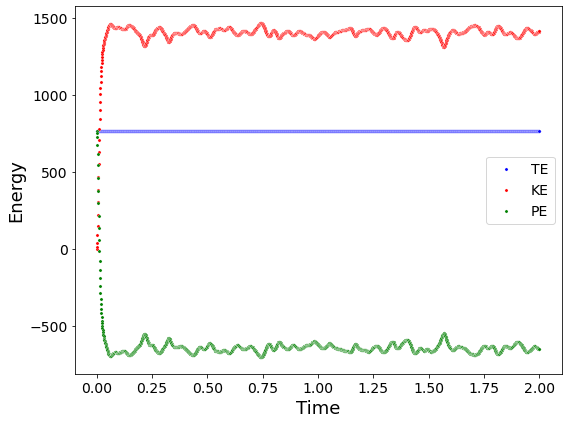

In [19]:
tim = np.linspace(0,Nsteps*dt,Nsteps)
plt.figure(figsize = (8,6))
ax = plt.axes()
plt.plot = sns.scatterplot(x = tim , y = TE, color = "blue", s = 10)
plt.plot = sns.scatterplot(x = tim , y = KE, color = "red", s = 10)
plt.plot = sns.scatterplot(x = tim , y = PE, color = "green", s = 10)
ax.legend(labels = ['TE','KE','PE'], fontsize = 14)
plt.xlabel("Time",fontsize = 18)
plt.ylabel("Energy", fontsize = 18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14) 
plt.tight_layout()
# ax.xaxis.set_major_locator(plt.MaxNLocator(8))
# ax.yaxis.set_major_locator(plt.MaxNLocator(8))
# plt.savefig(pathfil+city+'.png')
plt.show()
plt.close()